In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
import cv2
import glob

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/kaggleJson/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download anishkulung/5emotions
!unzip 5emotions

Streaming output truncated to the last 5000 lines.
  inflating: train/surprise/image0000020.jpg  
  inflating: train/surprise/image0000033.jpg  
  inflating: train/surprise/image0000038.jpg  
  inflating: train/surprise/image0000052.jpg  
  inflating: train/surprise/image0000079.jpg  
  inflating: train/surprise/image0000128.jpg  
  inflating: train/surprise/image0000137.jpg  
  inflating: train/surprise/image0000139.jpg  
  inflating: train/surprise/image0000152.jpg  
  inflating: train/surprise/image0000159.jpg  
  inflating: train/surprise/image0000186.jpg  
  inflating: train/surprise/image0000236.jpg  
  inflating: train/surprise/image0000243.jpg  
  inflating: train/surprise/image0000260.jpg  
  inflating: train/surprise/image0000281.jpg  
  inflating: train/surprise/image0000334.jpg  
  inflating: train/surprise/image0000377.jpg  
  inflating: train/surprise/image0000440.jpg  
  inflating: train/surprise/image0000442.jpg  
  inflating: train/surprise/image0000491.jpg  
  inflati

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def img_to_nparray(img):
    read_img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    dim=(75,75)
    resize_img = cv2.resize(read_img, dim, interpolation = cv2.INTER_AREA)
    img_to_array = np.array(resize_img)
    one_dim = img_to_array.flatten().astype(str)
    return one_dim

def append_to_list(tt_dir,xlist,ylist):

    for emo_dir in os.listdir(f'/content/{tt_dir}'):
        number_of_img = 0
        emotion=0
        
        if emo_dir == 'happy':
            emotion = 0
            
        if emo_dir == 'neutral':
            emotion = 1

        if emo_dir == 'sad':
            emotion = 2
        
        if emo_dir == 'surprise':
            emotion = 3
        
        for img in glob.iglob(os.path.join(f'/content/{tt_dir}/{emo_dir}',"*.jpg")):
            number_of_img +=1
            ylist.append(emotion)
            xlist.append(img_to_nparray(img))

        if(tt_dir =="train"):
            number_of_img_train[emotion] = number_of_img

        if(tt_dir =="test"):
            number_of_img_test[emotion] = number_of_img


train_test_dirs = ['train','test']
X_train = []
y_train = []

X_validation = []
y_validation = []

number_of_img_train = [0,0,0,0]
number_of_img_test = [0,0,0,0]

for dir in train_test_dirs:
    if dir == 'train':
        append_to_list(dir,X_train,y_train)
    append_to_list(dir,X_validation,y_validation)

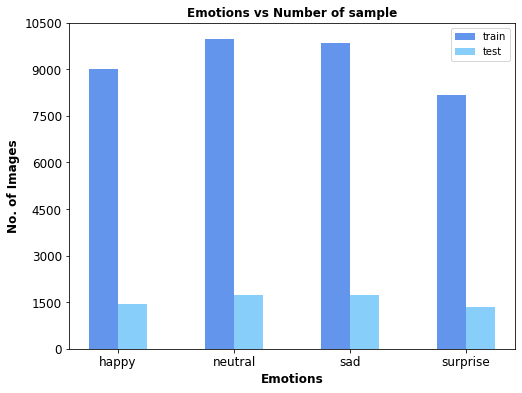

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

barWidth = 0.25
fig = plt.subplots(figsize =(8, 6))
 
# set height of bar
emotions = ["happy", "neutral", "sad", "surprise"]

# Set position of bar on X axis
br1 = np.arange(len(number_of_img_train))
br2 = [x + barWidth for x in br1]
 
# Make the plot
plt.bar(br1, number_of_img_train, color ='cornflowerblue', width = barWidth, label ='train')
plt.bar(br2, number_of_img_test, color ='lightskyblue', width = barWidth, label ='test')

 
# Adding Xticks
plt.xlabel('Emotions', fontweight ='bold', fontsize = 12)
plt.ylabel('No. of Images', fontweight ='bold', fontsize = 12)
plt.xticks(br1+barWidth/2,emotions,fontsize = 12)
plt.yticks(np.arange(0, 12000, step=1500), fontsize = 12)
plt.title("Emotions vs Number of sample",fontweight = 'bold',fontsize = 12)
 
plt.legend()
plt.show()

In [ ]:
#typecasting elements of list to integer
y_train = [int(x) for x in y_train]
y_validation = [int(x) for x in y_validation]

In [ ]:
#list to numpy array
X_train = np.array(X_train, dtype = 'uint8')
y_train = np.array(y_train, dtype = 'uint8')
X_validation = np.array(X_validation, dtype = 'uint8')
y_validation = np.array(y_validation, dtype = 'uint8')


In [ ]:

from tensorflow.keras.utils import to_categorical
y_train= to_categorical(y_train, num_classes=4)
y_validation = to_categorical(y_validation, num_classes=4)

In [ ]:
#reshaping data in the form of a 4d tensor(row_num, width, height, channel)
X_train = X_train.reshape(X_train.shape[0], 75, 75, 1)
X_validation = X_validation.reshape(X_validation.shape[0],75,75, 1)

In [ ]:
print(X_train.shape)

(49176, 75, 75, 1)


In [ ]:
from keras.preprocessing.image import ImageDataGenerator 
datagen = ImageDataGenerator( 
    rescale=1./255,
    rotation_range = 10,
    horizontal_flip = True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode = 'nearest',
    validation_split= 0.2)
testgen = ImageDataGenerator(rescale=1./255)
datagen.fit(X_train)
batch_size=64
#fitting the generator
train_flow = datagen.flow(X_train, y_train, batch_size=batch_size,shuffle=True) 
val_flow = testgen.flow(X_validation, y_validation, batch_size=batch_size)


In [ ]:

import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, BatchNormalization, Dropout,MaxPooling2D
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import CategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

In [ ]:
#CNN model
def FER_Model(input_shape=(75,75,1)):

    # first input model
    visible = Input(shape=input_shape, name='input')
    num_classes = 4

    #the 1-st block
    conv1_1 = Conv2D(64, kernel_size=3, activation='relu', kernel_regularizer = l2(0.001),padding='same', name = 'conv1_1')(visible)
    conv1_1 = BatchNormalization()(conv1_1)
    conv1_2 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'conv1_2')(conv1_1)
    conv1_2 = BatchNormalization()(conv1_2)
    pool1_1 = MaxPooling2D(pool_size=(2,2), name = 'pool1_1')(conv1_2)
    drop1_1 = Dropout(0.4, name = 'drop1_1')(pool1_1)
    #the 2-nd block
    conv2_1 = Conv2D(128, kernel_size=3, activation='relu', kernel_regularizer = l2(0.001),padding='same', name = 'conv2_1')(drop1_1)
    conv2_1 = BatchNormalization()(conv2_1)
    conv2_2 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_2')(conv2_1)
    conv2_2 = BatchNormalization()(conv2_2)
    conv2_3 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_3')(conv2_2)
    conv2_2 = BatchNormalization()(conv2_3)
    pool2_1 = MaxPooling2D(pool_size=(2,2), name = 'pool2_1')(conv2_3)
    drop2_1 = Dropout(0.4, name = 'drop2_1')(pool2_1)

    #the 3-rd block
    conv3_1 = Conv2D(256, kernel_size=3, activation='relu', kernel_regularizer = l2(0.001),padding='same', name = 'conv3_1')(drop2_1)
    conv3_1 = BatchNormalization()(conv3_1)
    conv3_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_2')(conv3_1)
    conv3_2 = BatchNormalization()(conv3_2)
    conv3_3 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_3')(conv3_2)
    conv3_3 = BatchNormalization()(conv3_3)
    conv3_4 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_4')(conv3_3)
    conv3_4 = BatchNormalization()(conv3_4)
    pool3_1 = MaxPooling2D(pool_size=(2,2), name = 'pool3_1')(conv3_4)
    drop3_1 = Dropout(0.4, name = 'drop3_1')(pool3_1)

    #the 4-th block
    conv4_1 = Conv2D(256, kernel_size=3, activation='relu', kernel_regularizer = l2(0.001),padding='same', name = 'conv4_1')(drop3_1)
    conv4_1 = BatchNormalization()(conv4_1)
    conv4_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_2')(conv4_1)
    conv4_2 = BatchNormalization()(conv4_2)
    conv4_3 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_3')(conv4_2)
    conv4_3 = BatchNormalization()(conv4_3)
    conv4_4 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_4')(conv4_3)
    conv4_4 = BatchNormalization()(conv4_4)
    pool4_1 = MaxPooling2D(pool_size=(2,2), name = 'pool4_1')(conv4_4)
    drop4_1 = Dropout(0.4, name = 'drop4_1')(pool4_1)
    
    #Flatten and output
    flatten = Flatten(name = 'flatten')(drop4_1)
    ouput = Dense(num_classes, activation='softmax', activity_regularizer = l2(0.001),name = 'output')(flatten)# create model 
    model = Model(inputs =visible, outputs = ouput)

    # summary layers
    print(model.summary())
    
    return model

In [ ]:
model = FER_Model()
optimizer = Adam(lr=0.0001, decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 75, 75, 1)]       0         
                                                                 
 conv1_1 (Conv2D)            (None, 75, 75, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 75, 75, 64)       256       
 ormalization)                                                   
                                                                 
 conv1_2 (Conv2D)            (None, 75, 75, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 75, 75, 64)       256       
 hNormalization)                                                 
                                                                 
 pool1_1 (MaxPooling2D)      (None, 37, 37, 64)        0     

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
batch_size =64
ck_filepath="weights-of-{epoch:02d}.h5"
check_pointer = ModelCheckpoint(filepath=ck_filepath,
                                save_freq = 5*769
                                )

early_stop = EarlyStopping(monitor='val_loss',
                           patience=2,
                           min_delta=0,
                           restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.0001)

In [ ]:
# plot_model(model,
#            to_file='baseline_conv.png',
#            show_shapes=True,
#            show_dtype=True,
#            show_layer_names=True)

In [ ]:
history = model.fit(train_flow,
                    validation_data = val_flow,
                    epochs = 50,
                    callbacks=[early_stop, check_pointer,reduce_lr])

Epoch 1/50
769/769 [==============================] - 297s 369ms/step - loss: 2.5438 - accuracy: 0.3365 - val_loss: 2.1950 - val_accuracy: 0.2306 - lr: 1.0000e-04
Epoch 2/50
769/769 [==============================] - 279s 363ms/step - loss: 2.1115 - accuracy: 0.3788 - val_loss: 1.8693 - val_accuracy: 0.4237 - lr: 1.0000e-04
Epoch 3/50
769/769 [==============================] - 279s 362ms/step - loss: 1.9564 - accuracy: 0.4268 - val_loss: 2.1248 - val_accuracy: 0.4417 - lr: 1.0000e-04
Epoch 4/50
769/769 [==============================] - 279s 363ms/step - loss: 1.7828 - accuracy: 0.4794 - val_loss: 1.6465 - val_accuracy: 0.5154 - lr: 1.0000e-04
Epoch 5/50
769/769 [==============================] - 280s 364ms/step - loss: 1.5939 - accuracy: 0.5165 - val_loss: 1.4778 - val_accuracy: 0.5614 - lr: 1.0000e-04
Epoch 6/50
769/769 [==============================] - 280s 364ms/step - loss: 1.4853 - accuracy: 0.5481 - val_loss: 1.4033 - val_accuracy: 0.5868 - lr: 1.0000e-04
Epoch 7/50
769/769 [==

### Index of model output
0    ->   happy, 
1    ->   neutral, 
2    ->   sad, 
3    ->   surprise


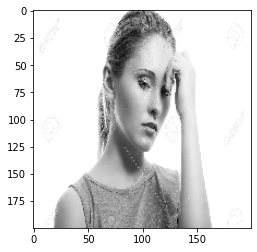

Expression Prediction: [[0.11342546 0.2755899  0.5232107  0.08777396]]


In [ ]:
from skimage import io
from keras.preprocessing import image
import matplotlib.pyplot as plt

img = image.load_img('/content/sad1.jpg', color_mode = "grayscale", target_size=(75, 75))
show_img=image.load_img('/content/sad1.jpg', color_mode = "grayscale", target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
plt.gray()
plt.imshow(show_img)
plt.show()

print('Expression Prediction:',custom)
        

In [ ]:
model_json = model.to_json()
with open("./model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("./model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
from google.colab import files
files.download('./model.json')
files.download('./model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install visualkeras

     |████████████████████████████████| 992 kB 8.1 MB/s 


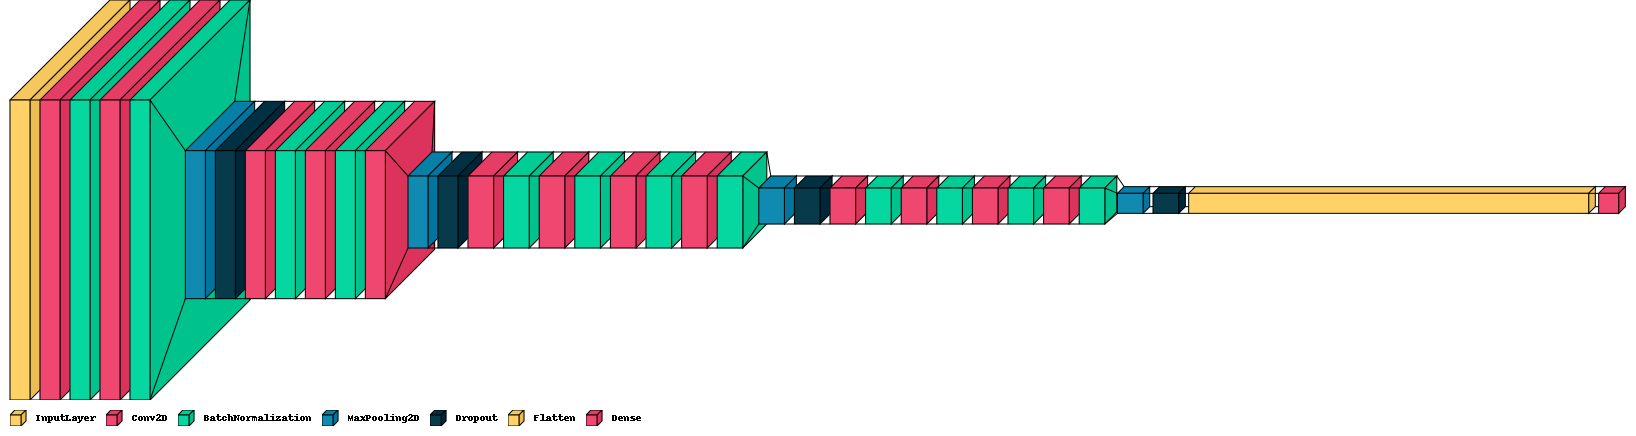

In [ ]:
import visualkeras
visualkeras.layered_view(model,legend=True)

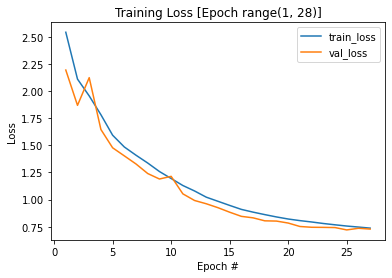

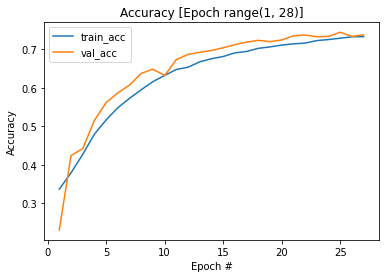

In [ ]:
#plotting loss vs accuracy
import matplotlib.pyplot as plt
loss_train = history.history['loss']
loss_val = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
N=range(1,28)
plt.figure()

plt.plot(N, loss_train, label = "train_loss")
plt.plot(N, loss_val, label = "val_loss")
plt.title("Training Loss [Epoch {}]".format(N))
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.figure()
plt.plot(N, train_acc, label = "train_acc")

plt.plot(N, val_acc, label = "val_acc")
plt.title("Accuracy [Epoch {}]".format(N))
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()